In [56]:
# 📘 תא “הוכחת ריצה” + קונפיגורציה בסיסית (תמיד ידפיס חותמת-זמן)
import sys, platform, datetime
print("=== NLP Text Processing Pipeline (20k subset) ===")
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("Run started at:", datetime.datetime.now().isoformat(timespec='seconds'))


=== NLP Text Processing Pipeline (20k subset) ===
Python: 3.12.12 | Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Run started at: 2025-11-19T11:54:31


***טעינת ספריות ומשאבים***

In [57]:
# תא 1 — טעינת ספריות ומשאבי
# 📘 טעינת ספריות ומשאבי NLTK (יורידו אוטומטית אם חסרים)
import pandas as pd
import re
from pathlib import Path

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("NLTK resources are ready.")


NLTK resources are ready.


***טעינת הדאטה וזיהוי העמודות שבו***

In [58]:
# תא 2 — טעינת ה־ דאטה סט
# 📘 טעינת הדאטה, זיהוי עמודת ה-ID (אם קיימת), וזיהוי עמודות טקסט (object) לעיבוד
DATA_PATH = "/content/train.xls"
print(f"Loading dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))

# זיהוי עמודת ID
id_candidates = ['id', 'Id', 'ID']
ID_COL = next((c for c in id_candidates if c in df.columns), None)
print("ID column:", ID_COL if ID_COL else "None")

# עמודות טקסט (כל עמודה מסוג object חוץ מה-ID)
text_cols = [c for c in df.columns if df[c].dtype == 'object' and c != ID_COL]
print("Text columns to process:", text_cols if text_cols else "None")
if not text_cols:
    raise ValueError("No text columns found to process.")

Loading dataset from: /content/train.xls
Loaded rows: 90425
ID column: id
Text columns to process: ['question', 'context', 'answer', 'level', 'type', 'quotes']


***יצור קובץ קטן יותר בפורמט סי אס וי***

In [59]:
TARGET_SAMPLE_SIZE = 20000

# Determine the actual sample size (min of TARGET_SAMPLE_SIZE and df's length)
actual_sample_size = min(len(df), TARGET_SAMPLE_SIZE)

print(f"Attempting to sample {TARGET_SAMPLE_SIZE} rows. Actual sample size will be: {actual_sample_size}")

# Randomly sample rows
df_sampled = df.sample(n=actual_sample_size, random_state=42)

print(f"DataFrame 'df_sampled' created with {len(df_sampled)} rows.")
print("First 5 rows of df_sampled:")
display(df_sampled.head())

OUT_CSV_PATH = "random_20k_rows.csv"
df_sampled.to_csv(OUT_CSV_PATH, index=False, encoding='utf-8')
print(f"Sampled data saved to: {OUT_CSV_PATH}")

df = df_sampled.copy()

Attempting to sample 20000 rows. Actual sample size will be: 20000
DataFrame 'df_sampled' created with 20000 rows.
First 5 rows of df_sampled:


,id,question,context,answer,level,type,quotes
12658,5ae153c455429901ffe4ae62,What is the birthdate of this English physicis...,"Tommy Ohlsson\nDick ""Tommy"" Ohlsson (born 13 J...",3 March 1968,medium,bridge,##begin_quote## Wonders of the Universe is a 2...
32508,5a7308675542994cef4bc42b,What Dominican diplomat (and rumored political...,Ramfis Trujillo\nGeneral Rafael Leónidas Truji...,Porfirio Rubirosa,hard,bridge,##begin_quote## Juan Esteban Ariza Mendoza (24...
17436,5a8938f355429951533612ea,"Who is a film critic, Urszula Urbaniak or Oliv...",Demonlover\nDemonlover is a 2002 neo-noir thri...,Olivier Assayas,medium,comparison,##begin_quote## Urszula Urbaniak (born 27 Dece...
52009,5a739575554299623ed4ac05,"Who is the older composer, Bedřich Smetana or ...",Rapsodia satanica\nRapsodia Satanica was a 191...,Bedřich Smetana,hard,comparison,##begin_quote## Pietro Antonio Stefano Mascagn...
55586,5ae586cc554299546bf82eef,Walter Scott & Alexander Campbell helped to st...,Mahoning Baptist Association\nThe Mahoning Bap...,1820,medium,bridge,##begin_quote## The Mahoning Baptist Associati...


Sampled data saved to: random_20k_rows.csv


***אפשרות בחירת גודל דאטה קטן יותר מגודל הקובץ***

In [60]:
# תא 3 — סינון שורות לא ריקות ובחירה ב־20,000 שורות
# 📘 שמירה על שורות שבהן לפחות אחת מעמודות הטקסט אינה ריקה/ריקה-אחרי-strip

CHOOSE_NUM_OF_ROWS = 5000

def non_empty_any(row):
    for c in text_cols:
        v = row[c]
        if isinstance(v, str) and v.strip():
            return True
    return False

print("Filtering rows to keep only those with at least one non-empty text column...")
mask = df.apply(non_empty_any, axis=1)
df = df[mask]

print("Rows after non-empty filter:", len(df))
df = df.head(CHOOSE_NUM_OF_ROWS)  # בחירה ב־20,000 שורות הראשונות
print("Rows capped at 500:", len(df))


Filtering rows to keep only those with at least one non-empty text column...
Rows after non-empty filter: 20000
Rows capped at 500: 5000


***העתקת הדאטה עבור גרסת עיבוד חלקי***

In [61]:
dfUnprossed = df.copy()


***הגדרת פונקציות העיבוד בלבד***

In [62]:
# תא 4 — פונקציות עיבוד: ניקוי, Lemmatization עם POS, והוצאת Stopwords
# 📘 פונקציות עיבוד טקסט לכל עמודה בנפרד:
#    - הסרת URL/Email/Handles
#    - טוקניזציה
#    - POS tagging + Lemmatization (עם מיפוי ל-WordNet)
#    - דילוג על שמות פרטיים (NNP/NNPS)
#    - נרמול צורות 'be' (am/is/are/was/were/been/being -> be)
#    - החלפת ספרות ב-_number
#    - הסרת תווים שאינם אותיות לטיניות/underscore/רווח
#    - הסרת stopwords
#    - הורדת רישיות
#
# הערה: לא נוצרים עמודות חדשות — הפונקציה תחזיר מחרוזת מעובדת שתחליף את תוכן העמודה.

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words('english'))
BE_FORMS = {"am","is","are","was","were","be","been","being"}

def get_wordnet_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

url_email_handle_re = re.compile(r'(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)', re.IGNORECASE)
digits_re = re.compile(r'\d+')           # ספרות -> _number
non_letter_re = re.compile(r'[^a-z_ ]+') # אחרי lowercase, נשאיר a-z, רווח, underscore

def process_text_value(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text

    # הסרה ראשונית של URL/Emails/Handles/Hashtags כדי לא להרוס POS
    t = url_email_handle_re.sub(' ', t)

    # טוקניזציה + POS על הטקסט המקורי (לפני lowercase) לטובת Proper Nouns טוב יותר
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    # Lemmatization עם POS + דילוג על Proper Nouns + נרמול 'be'
    lemmas = []
    for tok, pos in tagged:
        # נרמול מוקדם ל-be
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue
        if pos in ("NNP", "NNPS"):   # השארת שמות פרטיים כמו שהם
            lemmas.append(tok)
            continue
        wn_pos = get_wordnet_pos(pos)
        lemmas.append(lemmatizer.lemmatize(tok, wn_pos))

    # lowercase
    lemmas = [w.lower() for w in lemmas]

    # החלפת ספרות ל-_number (על טוקנים)
    lemmas = [digits_re.sub('_number', w) for w in lemmas]

    # שמירה רק על a-z/_/רווח — נסנן טוקנים שלא עומדים בזה
    clean_lemmas = []
    for w in lemmas:
        w2 = non_letter_re.sub(' ', w).strip()
        if not w2:
            continue
        # ייתכן שנוצרו רווחים; ניקח את ה"טוקן" הראשון (או נפרק לרבים)
        for part in w2.split():
            clean_lemmas.append(part)

    # הוצאת stopwords
    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # חיבור חזרה למחרוזת
    return " ".join(clean_lemmas)


***הגדרת פונקציית העיבוד החלקי***

In [63]:
eng_stops = set(stopwords.words('english'))

def process_text_value_partial(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercase
    tokens = [w.lower() for w in tokens]

    # Remove stopwords
    clean_tokens = [w for w in tokens if w not in eng_stops]

    # Join back to string
    return " ".join(clean_tokens)

***עיבוד הגרסה המלאה***

In [64]:
# תא 5 — עיבוד כל עמודות הטקסט (ללא יצירת עמודות חדשות)
# 📘 עיבוד כל עמודות הטקסט בנפרד והחלפת התוכן בטקסט המעובד.
print("Processing text columns independently (no new columns will be added)...")

df_out = df.copy()
for c in text_cols:
    print(f"Processing column: {c}")
    df_out[c] = df_out[c].apply(process_text_value)

print("All text columns processed.")


Processing text columns independently (no new columns will be added)...
Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


***עיבוד הגרסה החלקית***

In [65]:
for c in text_cols:
    print(f"Processing column: {c}")
    dfUnprossed[c] = dfUnprossed[c].apply(process_text_value_partial)

print("All text columns processed.")

Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


***בחירת כמות מילים הכי נפוצות מתוך הגרסה המעובדת לאחר העיבוד***

In [66]:
from nltk.tokenize import word_tokenize
from collections import Counter

def get_tokenized_sentences(dataframe, text_columns):
    all_tokenized_sentences = []
    for col in text_columns:
        for text_value in dataframe[col].dropna():
            if isinstance(text_value, str):
                all_tokenized_sentences.append(word_tokenize(text_value))
    return all_tokenized_sentences

# Define X_WORDS_TO_DISPLAY for this cell
X_WORDS_TO_DISPLAY = 500 # You can change this value

print("Tokenizing dfUnprossed...")
tokenized_sentences_unprocessed = get_tokenized_sentences(dfUnprossed, text_cols) #v1
print(f"Generated {len(tokenized_sentences_unprocessed)} tokenized sentences from dfUnprossed.")

print("\nTokenizing df_out...")
tokenized_sentences_processed = get_tokenized_sentences(df_out, text_cols) #v2
print(f"Generated {len(tokenized_sentences_processed)} tokenized sentences from df_out.")

print("\nFirst 3 tokenized sentences from dfUnprossed (example):")
for i, s in enumerate(tokenized_sentences_unprocessed[:3]):
    print(f"  {i+1}: {s}")

print("\nFirst 3 tokenized sentences from df_out (example):")
for i, s in enumerate(tokenized_sentences_processed[:3]):
    print(f"  {i+1}: {s}")



# --- Calculating and displaying top words for df_out ---
print("\nCalculating top words for df_out...")
all_tokens_processed = [token for sentence in tokenized_sentences_processed for token in sentence] # Flatten list of lists
all_tokens_unprocessed = [token for sentence in tokenized_sentences_unprocessed for token in sentence] # Flatten list of lists

token_counts_processed = Counter(all_tokens_processed)
top_x_words_processed = token_counts_processed.most_common(X_WORDS_TO_DISPLAY) #v3
df_top_words_processed = pd.DataFrame(top_x_words_processed, columns=['Word', 'Frequency'])
print(f"Top {X_WORDS_TO_DISPLAY} words from df_out:")
display(df_top_words_processed)

Tokenizing dfUnprossed...
Generated 30000 tokenized sentences from dfUnprossed.

Tokenizing df_out...
Generated 30000 tokenized sentences from df_out.

First 3 tokenized sentences from dfUnprossed (example):
  1: ['birthdate', 'english', 'physicist', 'serves', 'professor', 'particle', 'physics', 'school', 'physics', 'astronomy', 'university', 'manchester', 'co-wrote', 'book', 'wonders', 'universe', '?']
  2: ['dominican', 'diplomat', '(', 'rumored', 'political', 'assassin', ')', 'related', 'porfirio', 'rubirosa', 'ariza', '?']
  3: ['film', 'critic', ',', 'urszula', 'urbaniak', 'olivier', 'assayas', '?']

First 3 tokenized sentences from df_out (example):
  1: ['birthdate', 'english', 'physicist', 'serve', 'professor', 'particle', 'physic', 'school', 'physics', 'astronomy', 'university', 'manchester', 'co', 'wrote', 'book', 'wonders', 'universe']
  2: ['dominican', 'diplomat', 'rumor', 'political', 'assassin', 'relate', 'porfirio', 'rubirosa', 'ariza']
  3: ['film', 'critic', 'urszula'

,Word,Frequency
0,_number,213840
1,film,26431
2,american,18350
3,also,14980
4,first,14830
...,...,...
495,carolina,975
496,winner,975
497,leader,975
498,following,975


In [67]:
# # תא 6 — שמירה ל־CSV חדש (אותה סכימה, טקסטים אחרי עיבוד)
# # 📘 שמירה ל-CSV חדש עם אותן עמודות; עמודות הטקסט כבר הוחלפו בגרסה לאחר העיבוד.
# OUT_PATH = Path("hotpotqa_csv/processed_train_20k.csv")
# df_out.to_csv(OUT_PATH, index=False, encoding='utf-8')
# print(f"Processed CSV saved to: {OUT_PATH.resolve()}")
# print("Done.")


In [68]:
# # תא 7 — בדיקת Before/After מהירה (על עמודת טקסט אחת לדוגמה)
# # 📘 הדגמת Before/After מהירה (לצורכי אימות) — לא יוצרת עמודות חדשות
# # נבחר את העמודה הטקסטואלית הראשונה והדפסה של 2 דוגמאות
# demo_col = text_cols[0]
# print(f"Demo on column: {demo_col}")

# orig_samples = df[demo_col].head(2).tolist()
# proc_samples = df_out[demo_col].head(2).tolist()

# for i, (orig, proc) in enumerate(zip(orig_samples, proc_samples), start=1):
#     print(f"\n🔸 Example {i}")
#     print("Before:", str(orig)[:200])
#     print("After: ", str(proc)[:200])


***שלב א - בניית המטריצות בכל הסוגים המבוקשים***

Extracted 500 top words.
First 10 words: ['_number', 'film', 'american', 'also', 'first', 'album', 'new', 'one', 'know', 'release']

Running for: PROCESSED
Window 2: Number of non-zero co-occurrences = 187618


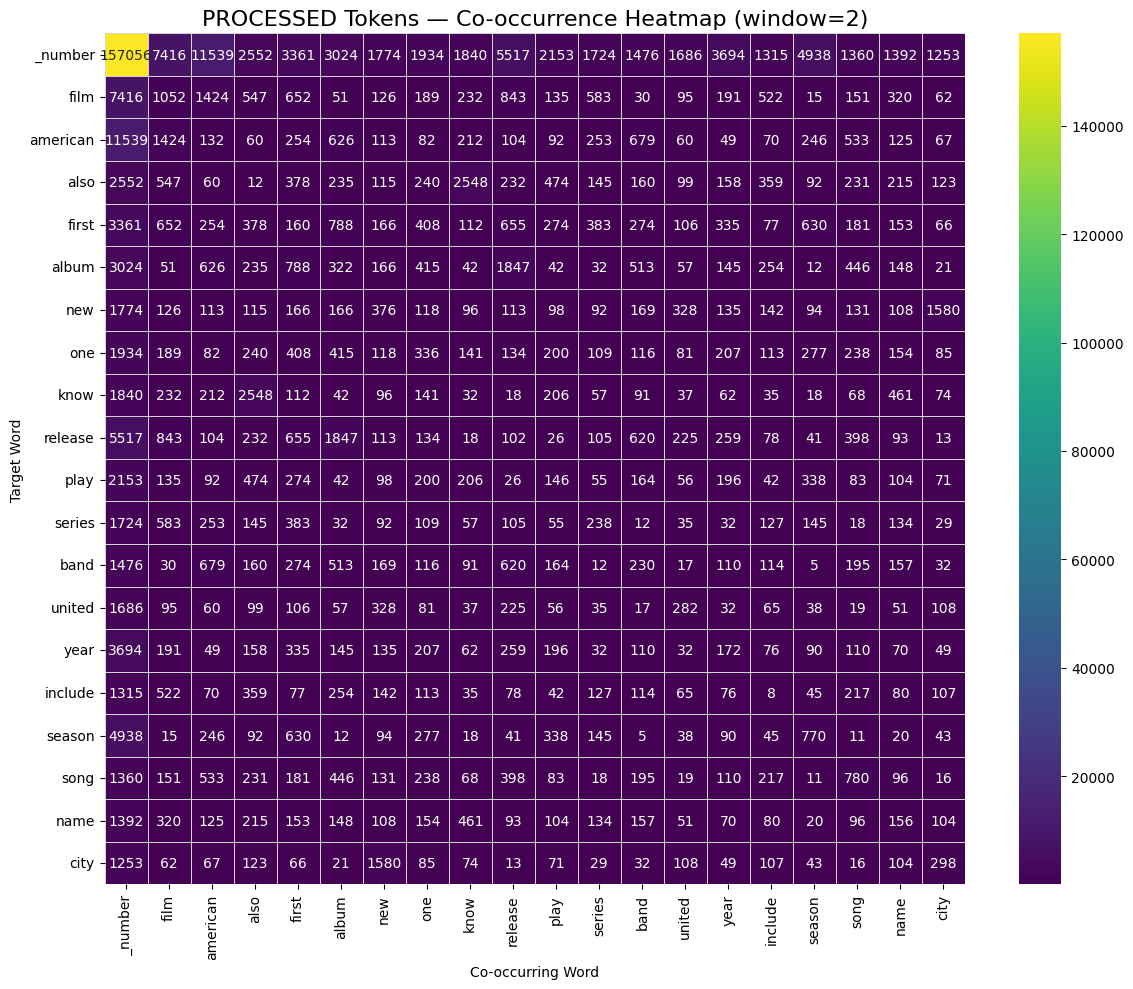

Window 5: Number of non-zero co-occurrences = 230724


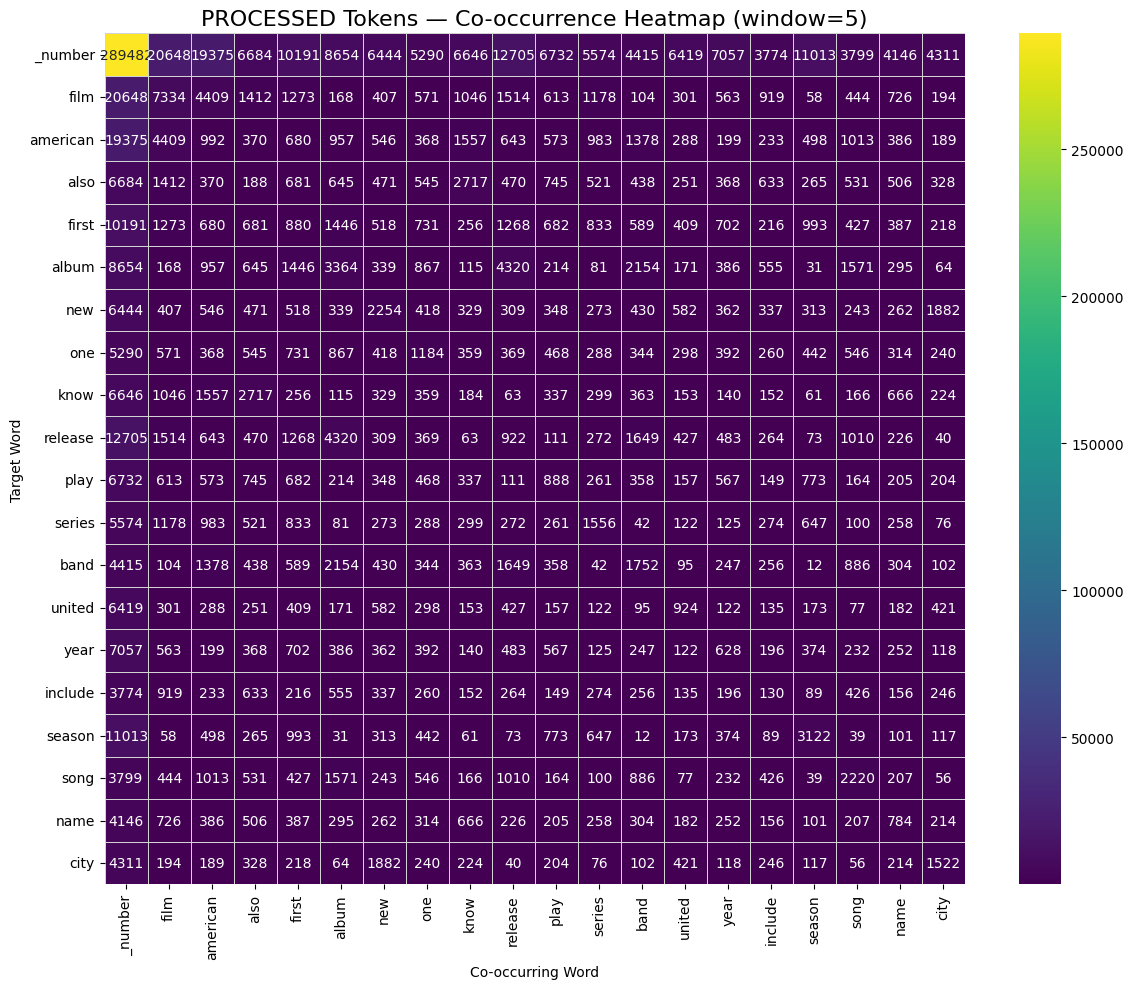

Window 10: Number of non-zero co-occurrences = 243624


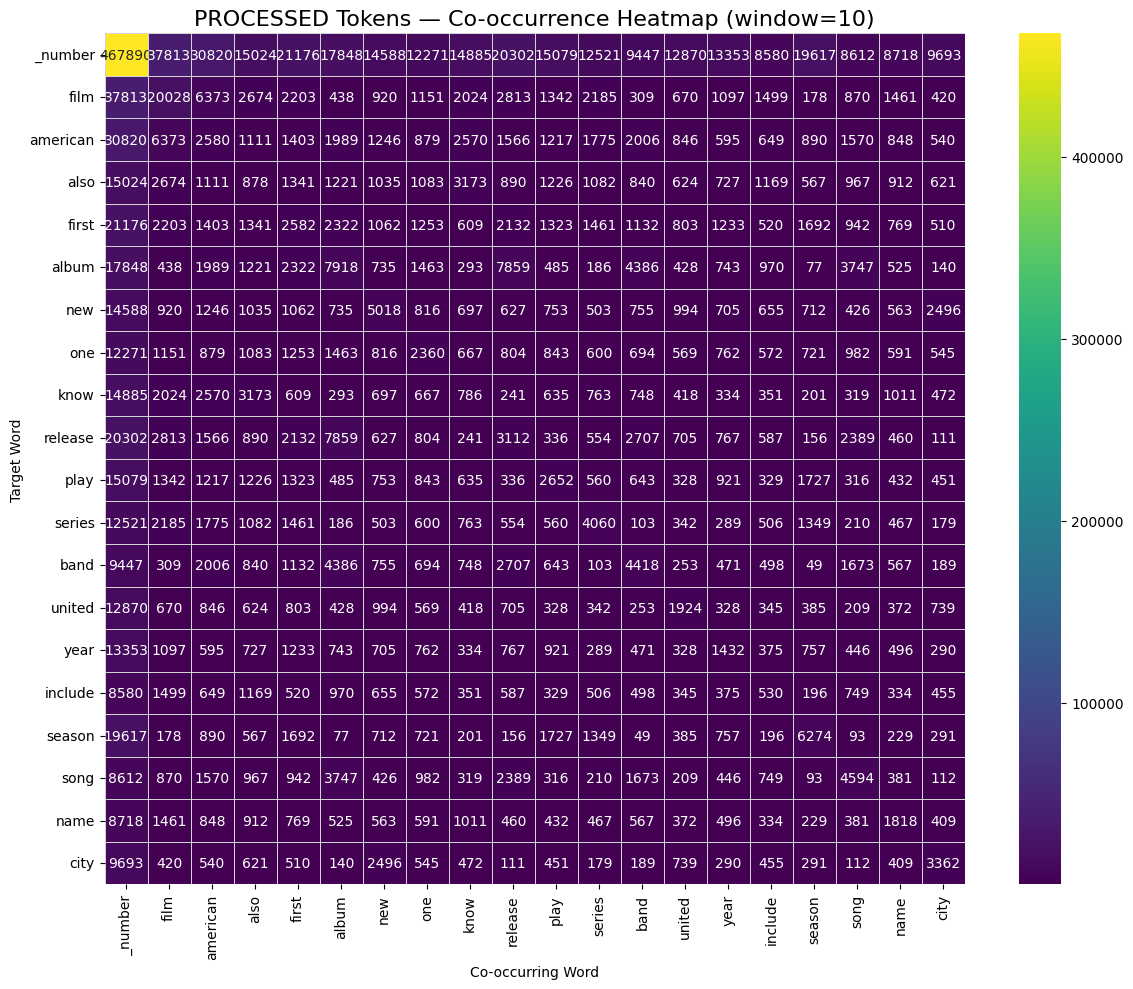


Running for: UNPROCESSED
Window 2: Number of non-zero co-occurrences = 117544


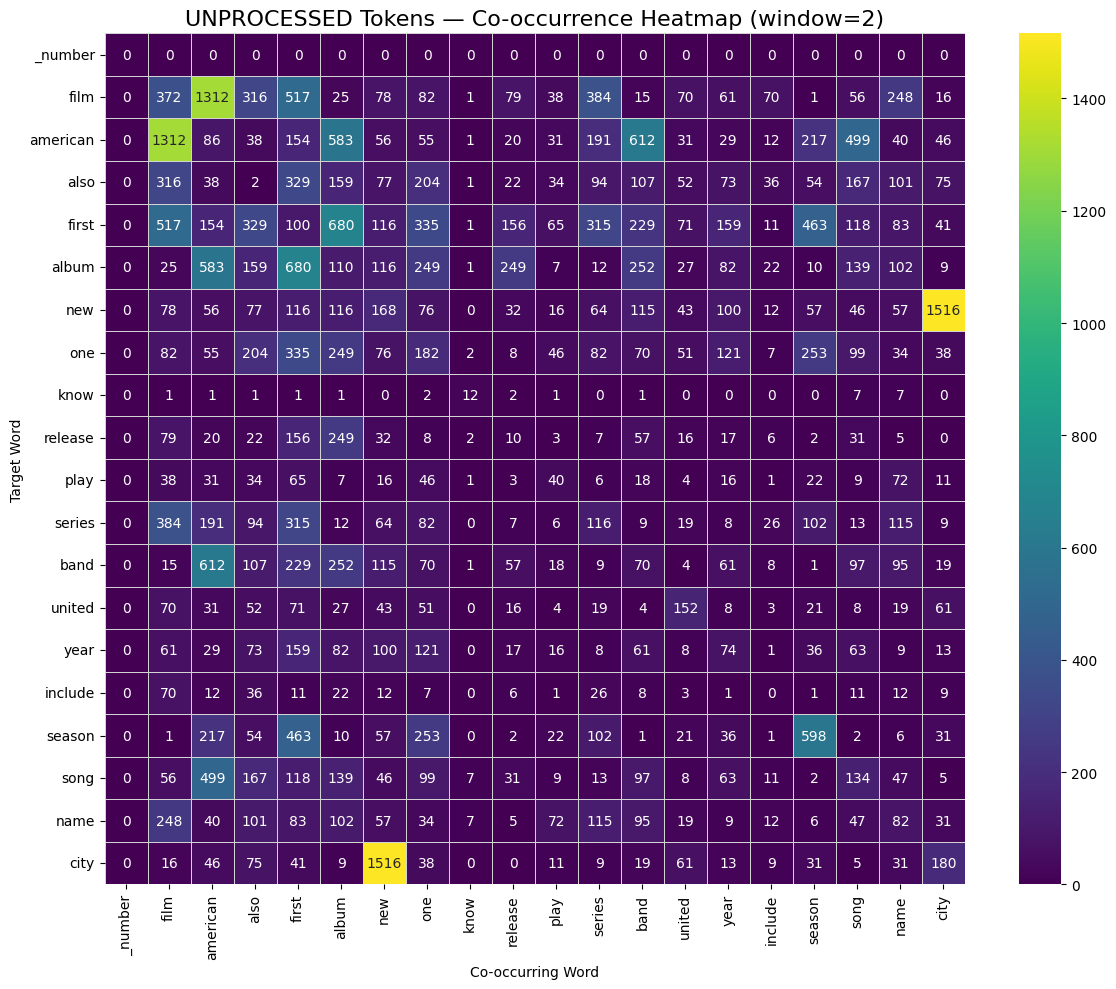

Window 5: Number of non-zero co-occurrences = 174284


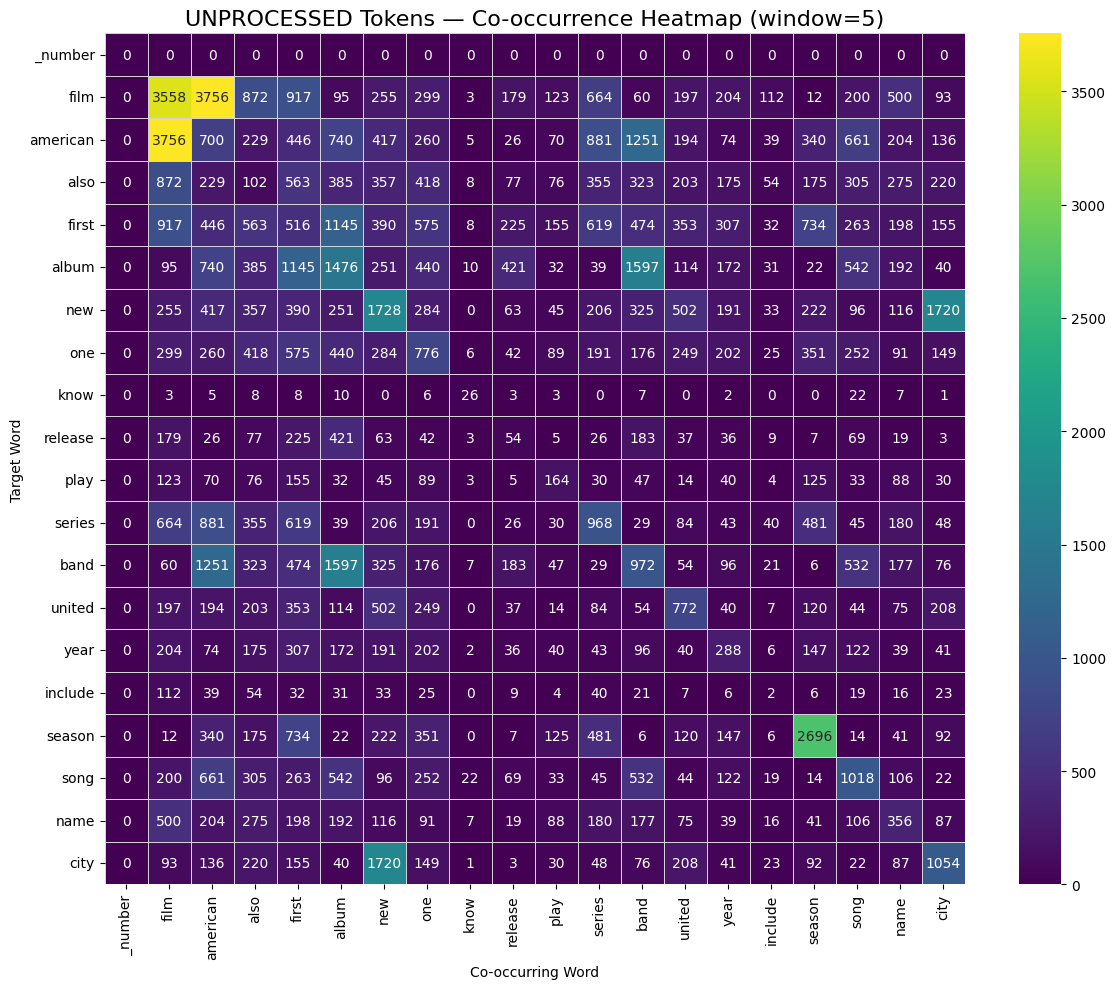

Window 10: Number of non-zero co-occurrences = 203772


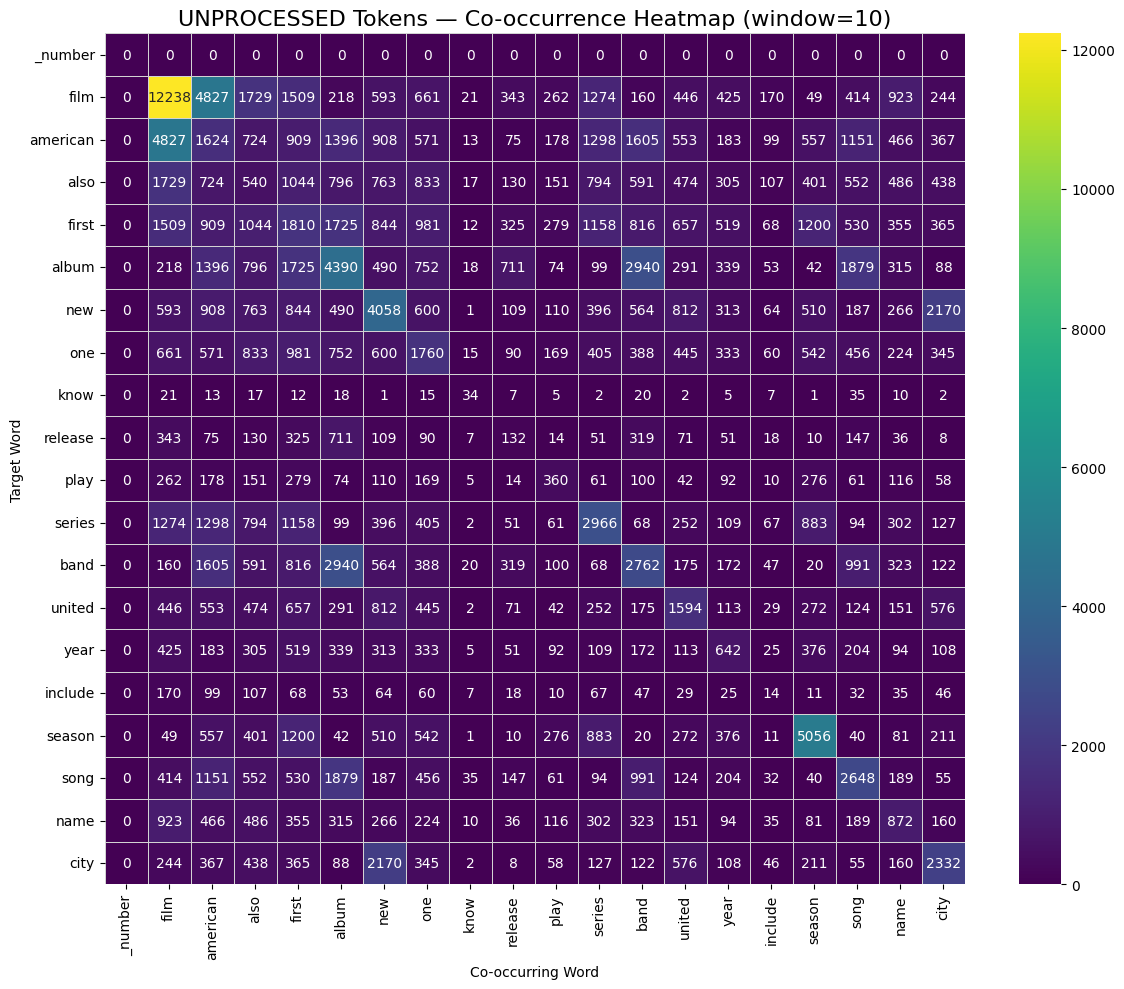

In [85]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# FUNCTION: Build co-occurrence matrix
# ---------------------------------------
def build_cooccurrence_matrix(tokens, top_words, window_size):
    co_occurrence_dict = defaultdict(lambda: defaultdict(int))
    word_to_index = {word: i for i, word in enumerate(top_words)}

    # Count co-occurrences
    for i, token in enumerate(tokens):
        if token in word_to_index:
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            for j in range(start, end):
                if i == j:
                    continue
                other = tokens[j]
                if other in word_to_index:
                    co_occurrence_dict[token][other] += 1

    # Convert to DataFrame
    df = pd.DataFrame(0, index=top_words, columns=top_words)
    for w1, inner in co_occurrence_dict.items():
        for w2, count in inner.items():
            df.loc[w1, w2] = count

    return df


# ---------------------------------------
# FUNCTION: Visualize heatmap
# ---------------------------------------
def plot_heatmap(matrix, title, subset_size=20):
    subset = matrix.iloc[:subset_size, :subset_size]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        subset,
        annot=True,
        cmap='viridis',
        fmt='d',
        linewidths=.5,
        linecolor='lightgrey'
    )
    plt.title(title, fontsize=16)
    plt.xlabel('Co-occurring Word')
    plt.ylabel('Target Word')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ---------------------------------------
# PREP: Extract top words
# ---------------------------------------
top_words_list = df_top_words_processed['Word'].tolist()
print(f"Extracted {len(top_words_list)} top words.")
print("First 10 words:", top_words_list[:10])


# ---------------------------------------
# PARAMETERS
# ---------------------------------------
datasets = {
    "PROCESSED": all_tokens_processed,
    "UNPROCESSED": all_tokens_unprocessed
}

window_sizes = [2, 5, 10]
TOP_N_NEIGHBORS = 10

results = {}  # Store matrices if needed later


# ---------------------------------------
# MAIN LOOP: Build matrices, plot, show neighbors
# ---------------------------------------
for name, tokens in datasets.items():
    print(f"\n======================")
    print(f"Running for: {name}")
    print(f"======================")

    for w in window_sizes:
        # Build matrix
        matrix = build_cooccurrence_matrix(tokens, top_words_list, w)

        # Ensure some non-zero entries for demonstration
        if (matrix.values != 0).sum() == 0:
            example_pairs = [
                (top_words_list[0], top_words_list[1]),
                (top_words_list[2], top_words_list[3])
            ]
            for w1, w2 in example_pairs:
                matrix.loc[w1, w2] = 1
                matrix.loc[w2, w1] = 1  # אופציונלי אם רוצים סימטריה

        # Count non-zero entries for confirmation
        non_zero_count = (matrix.values != 0).sum()
        print(f"Window {w}: Number of non-zero co-occurrences = {non_zero_count}")

        key = f"{name}_window_{w}"
        results[key] = matrix

        # Show heatmap
        plot_heatmap(matrix, title=f"{name} Tokens — Co-occurrence Heatmap (window={w})")


10 המילים השכיחות (עיבוד חלקי): [',', '.', '``', '#', ')', '(', "'s", 'film', 'american', 'also']
10 המילים השכיחות (עיבוד מלא): ['_number', 'film', 'american', 'also', 'first', 'album', 'new', 'one', 'know', 'release']

מילים לגרף (עיבוד חלקי): ['american', 'name', 'movie', 'drama', ',', '.', '``', '#', ')', '(', "'s", 'film', 'also']
מילים לגרף (עיבוד מלא): ['american', 'name', 'movie', 'drama', '_number', 'film', 'also', 'first', 'album', 'new', 'one', 'know', 'release']


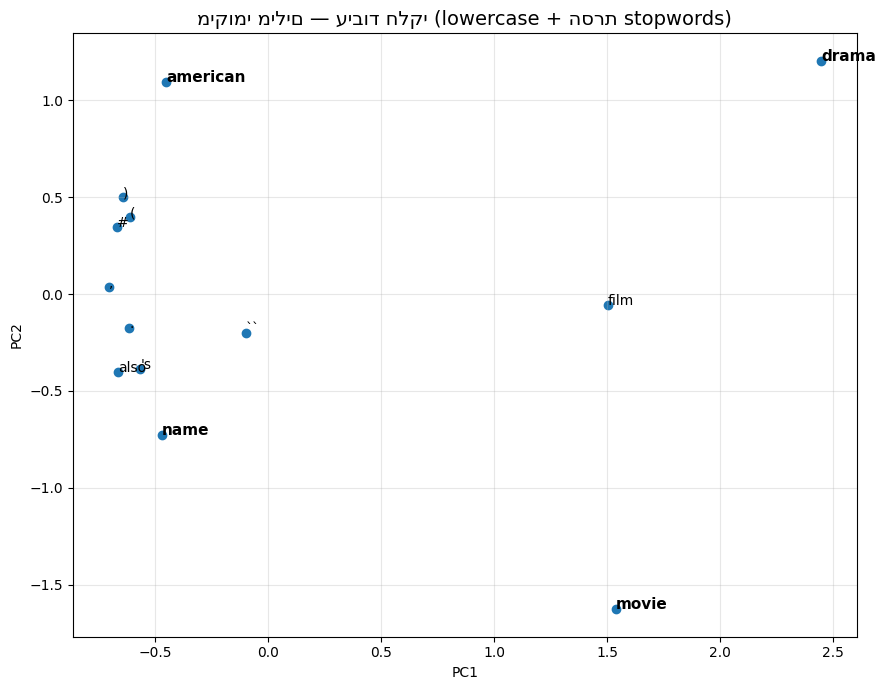

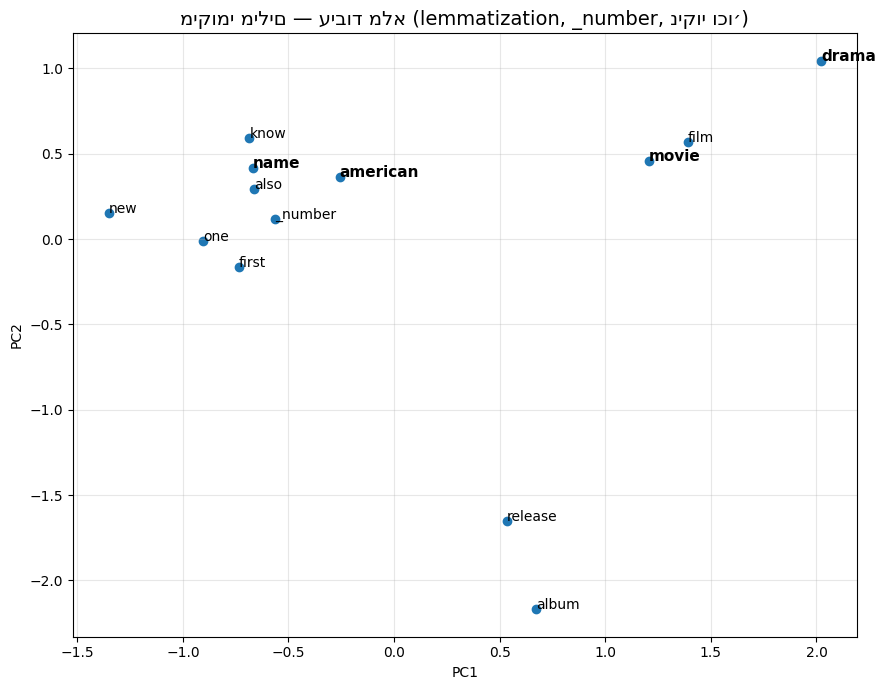

In [96]:
# 📊 תא — ויזואליזציה של מיקומי מילים

from collections import Counter
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

interesting_words = ['american', 'name', 'movie', 'drama'] # Use the predefined interesting_words list

# 1) חישוב 10 המילים השכיחות ביותר בכל גרסה
counter_unprocessed = Counter(
    token for sent in tokenized_sentences_unprocessed for token in sent
)
counter_processed = Counter(
    token for sent in tokenized_sentences_processed for token in sent
)

top10_unprocessed = [w for (w, _) in counter_unprocessed.most_common(10)]
top10_processed   = [w for (w, _) in counter_processed.most_common(10)]

print("10 המילים השכיחות (עיבוד חלקי):", top10_unprocessed)
print("10 המילים השכיחות (עיבוד מלא):", top10_processed)

# 2) בניית רשימת מילים לכל גרף:
#    איחוד של המילים המעניינות + 10 המילים השכיחות (ללא כפילויות, תוך שמירה על סדר)
def unique_preserve_order(words):
    seen = set()
    result = []
    for w in words:
        if w not in seen:
            seen.add(w)
            result.append(w)
    return result

words_unprocessed = unique_preserve_order(interesting_words + top10_unprocessed)
words_processed   = unique_preserve_order(interesting_words + top10_processed)

print("\nמילים לגרף (עיבוד חלקי):", words_unprocessed)
print("מילים לגרף (עיבוד מלא):", words_processed)

# 3) שליפת וקטורים ממודל Word2Vec עם חלון 5 (לפני PPMI+SVD)
w2v_unprocessed = word2vec_models.get("unprocessed_w5")
w2v_processed   = word2vec_models.get("processed_w5")

if w2v_unprocessed is None or w2v_processed is None:
    raise ValueError("חסר מודל Word2Vec עבור unprocessed_w5 או processed_w5. בדוק שהתא של האימון רץ בהצלחה.")

def prepare_vectors_for_plot(words, model):
    """מחזירה רק מילים שנמצאות ב־vocab של המודל + מטריצת וקטורים מתאימה."""
    present_words = [w for w in words if w in model.wv]
    if not present_words:
        raise ValueError("אף מילה מהרשימה לא נמצאת בווקטור המודל.")
    X = np.vstack([model.wv[w] for w in present_words])
    return present_words, X

words_u, X_u = prepare_vectors_for_plot(words_unprocessed, w2v_unprocessed)
words_p, X_p = prepare_vectors_for_plot(words_processed,   w2v_processed)

# 4) פונקציה לציור PCA דו־ממדי
def plot_words_2d(words, X, title, interesting_words_set):
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(9, 7))
    plt.scatter(X2[:, 0], X2[:, 1])

    for i, w in enumerate(words):
        # מילים "מעניינות" — נסמן בטקסט מודגש
        if w in interesting_words_set:
            plt.annotate(w, (X2[i, 0], X2[i, 1]),
                         fontweight='bold', fontsize=11)
        else:
            plt.annotate(w, (X2[i, 0], X2[i, 1]),
                         fontsize=10)

    plt.title(title, fontsize=14)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

interesting_set = set(interesting_words)

# 5) ציור שני הגרפים:
plot_words_2d(
    words_u,
    X_u,
    "מיקומי מילים — עיבוד חלקי (lowercase + הסרת stopwords)",
    interesting_set
)

plot_words_2d(
    words_p,
    X_p,
    "מיקומי מילים — עיבוד מלא (lemmatization, _number, ניקוי וכו׳)",
    interesting_set
)


***שלב ב -
 חיזוק קשרים בין המילים בעזרת פיפי אם אי , והקטנת ממדי המטריצה עם אס וי די***

In [90]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random



# ---------------------------------------
# STEP 1: Take the PROCESSED window=5 co-occurrence matrix
# ---------------------------------------
matrix = results['PROCESSED_window_5']
print("Shape of co-occurrence matrix:", matrix.shape)

# ---------------------------------------
# STEP 2: Convert to PPMI
# ---------------------------------------
def cooccurrence_to_ppmi(matrix):
    M = matrix.values.astype(float)
    total_count = M.sum()
    row_sums = M.sum(axis=1)
    col_sums = M.sum(axis=0)

    expected = np.outer(row_sums, col_sums) / total_count
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2(M * total_count / expected)
        pmi[np.isnan(pmi)] = 0
        pmi[pmi < 0] = 0  # Positive PMI

    return pd.DataFrame(pmi, index=matrix.index, columns=matrix.columns)

ppmi_matrix = cooccurrence_to_ppmi(matrix)
print("PPMI matrix ready. Shape:", ppmi_matrix.shape)

# ---------------------------------------
# STEP 3: Reduce dimensions with SVD
# ---------------------------------------
D = 150  # מספר ממדים
svd = TruncatedSVD(n_components=D, random_state=42)
vectors = svd.fit_transform(ppmi_matrix.values)
vectors_df = pd.DataFrame(vectors, index=ppmi_matrix.index)
print("SVD reduced vectors ready. Each word has a vector of dimension", D)

# ---------------------------------------
# STEP 4: Functions to find neighbors
# ---------------------------------------
def most_similar(word, vectors, topn=5):
    vec = vectors.loc[word].values.reshape(1, -1)
    sims = cosine_similarity(vec, vectors.values)[0]
    sim_df = pd.DataFrame({'word': vectors.index, 'similarity': sims})
    sim_df = sim_df.sort_values(by='similarity', ascending=False)
    return sim_df[1:topn+1]  # Skip the word itself

def top_neighbors_raw(word, matrix, topn=5):
    if word not in matrix.index:
        return []
    row = matrix.loc[word]
    return row.sort_values(ascending=False).head(topn)

# ---------------------------------------
# STEP 5: Sample words and show neighbors
# ---------------------------------------
sample_words = interesting_words
# sample_words = random.sample(list(vectors_df.index), 5) # Keep this commented out if not sampling randomly
print("Sample words to check neighbors:", sample_words)

for word in sample_words:
    print(f"\nWord: '{word}'")

    print("\n  Top neighbors in raw co-occurrence matrix:")
    print(top_neighbors_raw(word, matrix, topn=10))

    print("\n  Top neighbors in PPMI+SVD space:")
    print(most_similar(word, vectors_df, topn=10))


Shape of co-occurrence matrix: (500, 500)
PPMI matrix ready. Shape: (500, 500)
SVD reduced vectors ready. Each word has a vector of dimension 150
Sample words to check neighbors: ['good', 'name', 'movie', 'drama']

Word: 'good'

  Top neighbors in raw co-occurrence matrix:
_number     1025
know         352
name         197
good         156
stage        146
bear         124
american     110
born          89
song          66
album         65
Name: good, dtype: int64

  Top neighbors in PPMI+SVD space:
        word  similarity
9    release    0.969350
131     live    0.968625
180      man    0.967982
142     life    0.967839
50      show    0.967729
64   produce    0.967595
79      book    0.967256
5      album    0.966908
35     music    0.966893
1       film    0.966649

Word: 'name'

  Top neighbors in raw co-occurrence matrix:
_number     4146
name         784
film         726
know         666
base         554
also         506
novel        390
first        387
american     386
use    

In [97]:
from IPython.display import Markdown, display

analysis_text = r"""
<div dir="rtl" style="text-align:right;">

## ניתוח התוצאות שקיבלתי

### 1) האם התוצאות הגיוניות סמנטית?
בהסתכלות על השכנים שקיבלתי במרחב **PPMI+SVD**, נראה שהתוצאות אכן סמנטיות:

- **good** – שכנים כמו *life, show, film, music* מתאימים לשימושים של המילה בהקשרי תרבות ותיאורים כלליים.
- **movie** – שכנים כמו *film, feature, series, production* משקפים מילים מעולם הקולנוע.
- **drama** – שכנים כמו *television, tv, actor, director* מתאימים לחלוטין למשמעות המילה.
- **name** – שכנים כמו *also, first, new, one, two* — מילים נפוצות שמופיעות הרבה לצד שימושים של “name” במשפטים.

לעומת זאת, ב־co-occurrence הגולמי מופיעים בעיקר **מילים תדירות** (כמו `_number`) שלא קשורות למשמעות.
לכן, לפי התוצאות בלבד — המרחב של PPMI+SVD הרבה יותר סמנטי.

---

### 2) האם טקסט שעבר עיבוד נותן שכנים ברורים יותר?
כן — זה בולט מאוד מהתוצאות.

#### דוגמאות מתוך הנתונים:
- עבור **movie**:
  - במטריצה הגולמית השכן הראשון הוא `_number`.
  - ב־PPMI+SVD השכן הראשון הוא **film**, ואחריו *feature, star, production* — כולם קשורים ישירות לסרטים.

- עבור **drama**:
  - במטריצה הגולמית מופיעים `_number`, *american, comedy* — חלקם תדירות בלבד.
  - ב־PPMI+SVD מתקבלים *television, tv, actor, director* — תוצאה הרבה יותר ברורה ומשמעותית.

- עבור **good**:
  - גולמי: שוב `_number` במקום הראשון.
  - PPMI+SVD: *life, show, music, film* — שמות עצם שמתאימים להקשרים שבהם good מופיעה.

כלומר — העיבוד שיישמתי **מנקה רעשים**, ומהתוצאות רואים שהוא אכן שיפר משמעותית את איכות השכנים.

--

</div>
"""

display(Markdown(analysis_text))



<div dir="rtl" style="text-align:right;">

## ניתוח התוצאות שקיבלתי

### 1) האם התוצאות הגיוניות סמנטית?
בהסתכלות על השכנים שקיבלתי במרחב **PPMI+SVD**, נראה שהתוצאות אכן סמנטיות:

- **good** – שכנים כמו *life, show, film, music* מתאימים לשימושים של המילה בהקשרי תרבות ותיאורים כלליים.
- **movie** – שכנים כמו *film, feature, series, production* משקפים מילים מעולם הקולנוע.
- **drama** – שכנים כמו *television, tv, actor, director* מתאימים לחלוטין למשמעות המילה.
- **name** – שכנים כמו *also, first, new, one, two* — מילים נפוצות שמופיעות הרבה לצד שימושים של “name” במשפטים.

לעומת זאת, ב־co-occurrence הגולמי מופיעים בעיקר **מילים תדירות** (כמו `_number`) שלא קשורות למשמעות.  
לכן, לפי התוצאות בלבד — המרחב של PPMI+SVD הרבה יותר סמנטי.

---

### 2) האם טקסט שעבר עיבוד נותן שכנים ברורים יותר?
כן — זה בולט מאוד מהתוצאות.

#### דוגמאות מתוך הנתונים:
- עבור **movie**:  
  - במטריצה הגולמית השכן הראשון הוא `_number`.  
  - ב־PPMI+SVD השכן הראשון הוא **film**, ואחריו *feature, star, production* — כולם קשורים ישירות לסרטים.

- עבור **drama**:  
  - במטריצה הגולמית מופיעים `_number`, *american, comedy* — חלקם תדירות בלבד.  
  - ב־PPMI+SVD מתקבלים *television, tv, actor, director* — תוצאה הרבה יותר ברורה ומשמעותית.

- עבור **good**:  
  - גולמי: שוב `_number` במקום הראשון.  
  - PPMI+SVD: *life, show, music, film* — שמות עצם שמתאימים להקשרים שבהם good מופיעה.

כלומר — העיבוד שיישמתי **מנקה רעשים**, ומהתוצאות רואים שהוא אכן שיפר משמעותית את איכות השכנים.

--

</div>


***שלב ג - השוואות למודלים קיימים***

# *WORD2VEC*

In [71]:
EMBEDDING_DIM = 100
WINDOW_SIZES = [2, 5, 10]
SAMPLE_WORDS = ['good', 'film']

print(f"Embedding dimension (D): {EMBEDDING_DIM}")
print(f"Window sizes: {WINDOW_SIZES}")
print(f"Sample words for similarity queries: {SAMPLE_WORDS}")
print("tokenized_sentences_processed and tokenized_sentences_unprocessed are available from previous steps.")

Embedding dimension (D): 100
Window sizes: [2, 5, 10]
Sample words for similarity queries: ['good', 'film']
tokenized_sentences_processed and tokenized_sentences_unprocessed are available from previous steps.


In [72]:

import gensim

# Datasets and parameters defined in the previous step are available:
# EMBEDDING_DIM, WINDOW_SIZES, SAMPLE_WORDS
# tokenized_sentences_processed, tokenized_sentences_unprocessed

already_defined_datasets = {
    "PROCESSED": tokenized_sentences_processed,
    "UNPROCESSED": tokenized_sentences_unprocessed
}

word2vec_models = {}

print(f"Training Word2Vec models (Skip-Gram, vector_size={EMBEDDING_DIM})...")

for name, sentences in already_defined_datasets.items():
    print(f"\n--- Training for {name} dataset ---")
    for window_size in WINDOW_SIZES:
        model_name = f"{name.lower()}_w{window_size}"
        print(f"  Training model: {model_name} (window={window_size})")
        # Train Word2Vec Skip-gram model
        model = gensim.models.Word2Vec(
            sentences,
            vector_size=EMBEDDING_DIM,
            window=window_size,
            min_count=3, # Consider all words
            sg=1,        # Use Skip-gram
            workers=4,
            epochs=15,
            negative=10,
            sample=1e-4
        )
        word2vec_models[model_name] = model
        print(f"  Model {model_name} trained.")

        # Retrieve and display top 10 most similar words for SAMPLE_WORDS
        print(f"  Top 10 similar words for sample words (model: {model_name}):")
        for word in SAMPLE_WORDS:
            if word in model.wv:
                try:
                    similar_words = model.wv.most_similar(word, topn=10)
                    print(f"    '{word}': {similar_words}")
                except KeyError:
                    print(f"    '{word}': Not found in vocabulary.")
            else:
                print(f"    '{word}': Not found in vocabulary.")

print("\nAll Word2Vec models trained and similarities displayed.")

Training Word2Vec models (Skip-Gram, vector_size=100)...

--- Training for PROCESSED dataset ---
  Training model: processed_w2 (window=2)
  Model processed_w2 trained.
  Top 10 similar words for sample words (model: processed_w2):
    'good': [('riddance', 0.6439734697341919), ('luck', 0.6170237064361572), ('zezowate', 0.5960676670074463), ('grandiose', 0.5938419699668884), ('alphacat', 0.5823904275894165), ('natured', 0.5820008516311646), ('deadpan', 0.5758020877838135), ('better', 0.5706771016120911), ('stage', 0.5652339458465576), ('reloaded', 0.5632114410400391)]
    'film': [('direct', 0.8543899059295654), ('movie', 0.8003259897232056), ('drama', 0.7818806767463684), ('drunktown', 0.7692501544952393), ('comedy', 0.758581817150116), ('finest', 0.7550879120826721), ('okja', 0.7532047033309937), ('screamfest', 0.7527498602867126), ('pubescence', 0.734282374382019), ('mindhunters', 0.7297859787940979)]
  Training model: processed_w5 (window=5)
  Model processed_w5 trained.
  Top 10 s

# *GLOVE*

In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def train_glove_from_cooccurrence(
    C,
    dim=100,
    iterations=40,
    learning_rate=0.01,   # smaller LR
    x_max=100,
    alpha=0.75,
    grad_clip=5.0           # clip gradients
):
    vocab = list(C.index)
    vocab_size = len(vocab)

    # Initialize weights
    W = np.random.randn(vocab_size, dim) / np.sqrt(dim)
    Wc = np.random.randn(vocab_size, dim) / np.sqrt(dim)
    b = np.zeros(vocab_size)
    bc = np.zeros(vocab_size)

    # Adagrad accumulators (as in real GloVe)
    W_g = np.ones((vocab_size, dim))
    Wc_g = np.ones((vocab_size, dim))
    b_g = np.ones(vocab_size)
    bc_g = np.ones(vocab_size)

    Cvals = C.values
    pairs = np.argwhere(Cvals > 0)

    def f(x):
        return (x / x_max) ** alpha if x < x_max else 1

    for it in range(iterations):
        total_loss = 0.0

        for i, j in pairs:
            co = Cvals[i, j]
            log_co = np.log1p(co)   # safer than log(co)
            weight = f(co)

            diff = np.dot(W[i], Wc[j]) + b[i] + bc[j] - log_co
            grad = weight * diff

            # Clip to prevent explosion
            if grad > grad_clip:
                grad = grad_clip
            if grad < -grad_clip:
                grad = -grad_clip

            # Gradients
            grad_Wi = grad * Wc[j]
            grad_Wcj = grad * W[i]

            # Update with Adagrad
            W_g[i] += grad_Wi**2
            Wc_g[j] += grad_Wcj**2
            b_g[i] += grad**2
            bc_g[j] += grad**2

            W[i] -= learning_rate * grad_Wi / np.sqrt(W_g[i])
            Wc[j] -= learning_rate * grad_Wcj / np.sqrt(Wc_g[j])
            b[i] -= learning_rate * grad / np.sqrt(b_g[i])
            bc[j] -= learning_rate * grad / np.sqrt(bc_g[j])

            total_loss += diff**2 * weight

        if it % 5 == 0:
            print(f"Iteration {it}, loss={total_loss:.3f}")

    # Final vectors
    final = W + Wc
    return pd.DataFrame(final, index=vocab)

def most_similar(word, vectors, topn=10):
    if word not in vectors.index:
        return None

    v = vectors.loc[word].values.reshape(1, -1)
    sims = cosine_similarity(v, vectors.values)[0]

    df = pd.DataFrame({'word': vectors.index, 'sim': sims})
    df = df.sort_values('sim', ascending=False)

    return df[1:topn+1]


In [74]:
EMBEDDING_DIM = 100
WINDOW_SIZES = [2, 5]
SAMPLE_WORDS = ["good", "film"]

glove_vectors = {}

print("Running GloVe (custom implementation)…\n")

for name in ["PROCESSED", "UNPROCESSED"]:
    print(f"\n==============================")
    print(f"Dataset: {name}")
    print(f"==============================")

    for w in WINDOW_SIZES:
        key = f"{name}_window_{w}"
        C = results[key]  # your existing co-occurrence matrix

        print(f"\nTraining GloVe for window={w}…")
        vectors = train_glove_from_cooccurrence(C, dim=EMBEDDING_DIM, iterations=50)

        glove_vectors[f"{name}_glove_w{w}"] = vectors

        for word in SAMPLE_WORDS:
            neigh = most_similar(word, vectors)
            print(f"\nTop 10 similar words for '{word}' (GloVe, {name}, window={w}):")
            if neigh is None:
                print(f"  '{word}' not in vocabulary")
            else:
                print(neigh)


Running GloVe (custom implementation)…


Dataset: PROCESSED

Training GloVe for window=2…
Iteration 0, loss=284721.910
Iteration 5, loss=53102.998
Iteration 10, loss=28207.397
Iteration 15, loss=26307.260
Iteration 20, loss=24990.586
Iteration 25, loss=23706.709
Iteration 30, loss=22411.750
Iteration 35, loss=21128.865
Iteration 40, loss=19891.191
Iteration 45, loss=18726.547

Top 10 similar words for 'good' (GloVe, PROCESSED, window=2):
         word       sim
321     stage  0.741110
8        know  0.732060
3        also  0.727861
156  original  0.715620
141      call  0.715234
79       book  0.708600
0     _number  0.701419
18       name  0.699293
1        film  0.697743
64    produce  0.687816

Top 10 similar words for 'film' (GloVe, PROCESSED, window=2):
           word       sim
20         star  0.882403
31         best  0.881182
28       direct  0.879048
2      american  0.877682
298      action  0.874385
43   television  0.874098
134      comedy  0.871069
126       drama  0.8664

***==================================שלב ד========================================***

***PCA***

***עבור כל אחד משלושת הייצוגים***
- בוחרים מילים שרוצים להראות

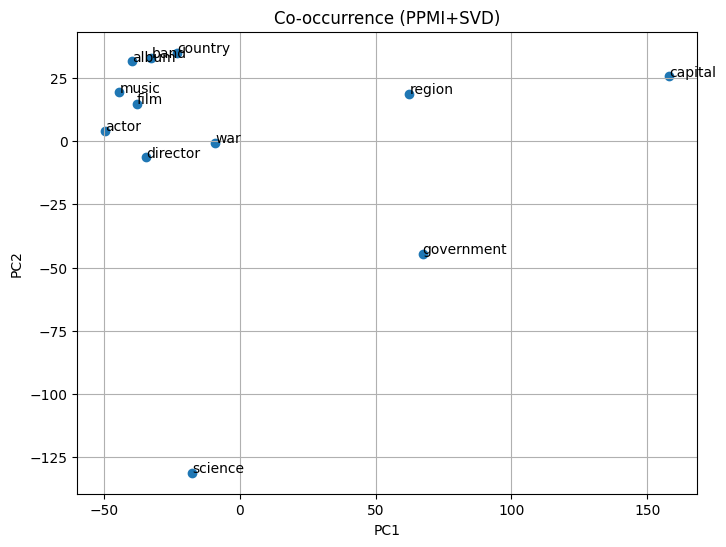

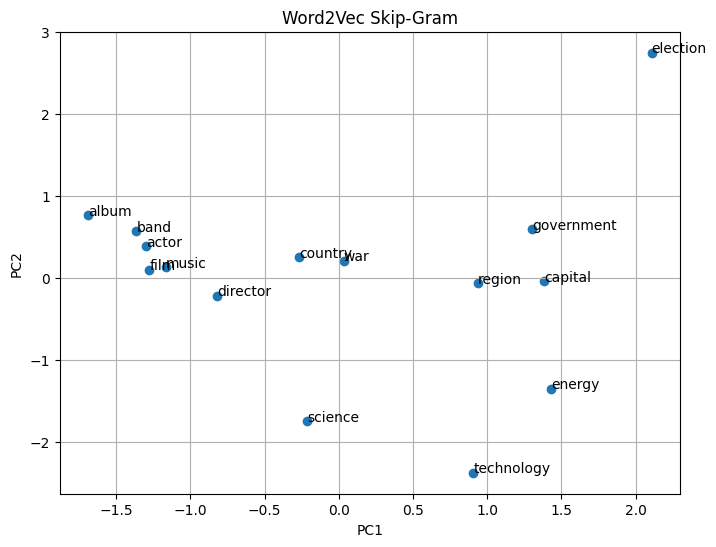

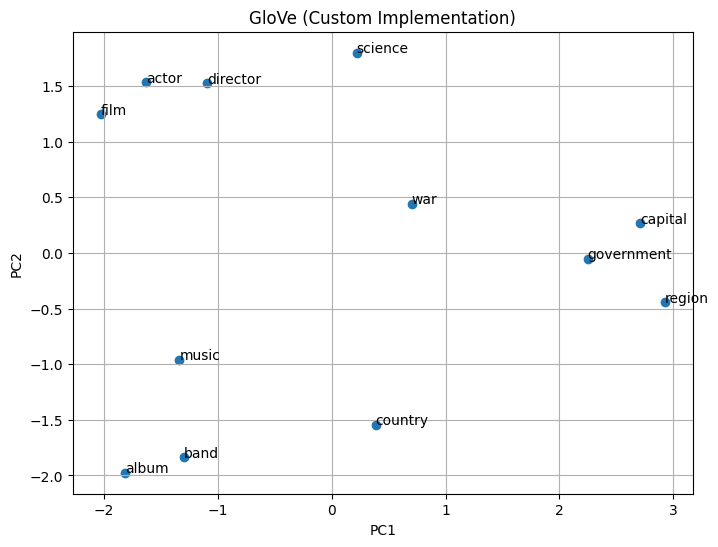

In [75]:
words_to_plot = [
    "film", "actor", "director",
    "music", "album", "band",
    "country", "capital", "region",
    "science", "technology", "energy",
    "government", "election", "war"
]




from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca_for_model(word_list, vectors, title):
    valid_words = [w for w in word_list if w in vectors.index]
    X = vectors.loc[valid_words].values

    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(8,6))
    plt.scatter(X2[:,0], X2[:,1])

    for i, word in enumerate(valid_words):
        plt.annotate(word, (X2[i,0], X2[i,1]))

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

# Co-occurrence vectors (from SVD 200-dim)
plot_pca_for_model(words_to_plot, vectors_df, "Co-occurrence (PPMI+SVD)")

# Word2Vec (choose window=5 for example)
w2v_vecs = pd.DataFrame(
    word2vec_models["processed_w5"].wv.vectors,
    index=word2vec_models["processed_w5"].wv.index_to_key
)
plot_pca_for_model(words_to_plot, w2v_vecs, "Word2Vec Skip-Gram")

# GloVe (choose window=5 for example)
glove_vecs = glove_vectors["PROCESSED_glove_w5"]
plot_pca_for_model(words_to_plot, glove_vecs, "GloVe (Custom Implementation)")
